In [ ]:
import torch

In [ ]:
import torchvision 
from torchvision import datasets, transforms
from torch.utils.data import random_split, DataLoader


In [ ]:

train_transform = transforms.Compose([
    transforms.RandomCrop(32),
    transforms.ToTensor()
])
test_transform = transforms.Compose([
    transforms.ToTensor()                                                       
])
train = datasets.CIFAR10(root='data/', train=True, download= True, transform=train_transform )
test = datasets.CIFAR10(root='data/', train=False, download= True, transform=test_transform)


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/cifar-10-python.tar.gz to data/
Files already downloaded and verified


In [ ]:
val_ratio = 0.2
train_dataset, val_dataset = random_split(train, [int((1-val_ratio) * len(train)), int(val_ratio*len(train))])
batch_size= 64
trainset = DataLoader(train_dataset, batch_size , shuffle=True)
val_dl = DataLoader(val_dataset, batch_size , shuffle=True)
testset = DataLoader(test, batch_size , shuffle=True) 

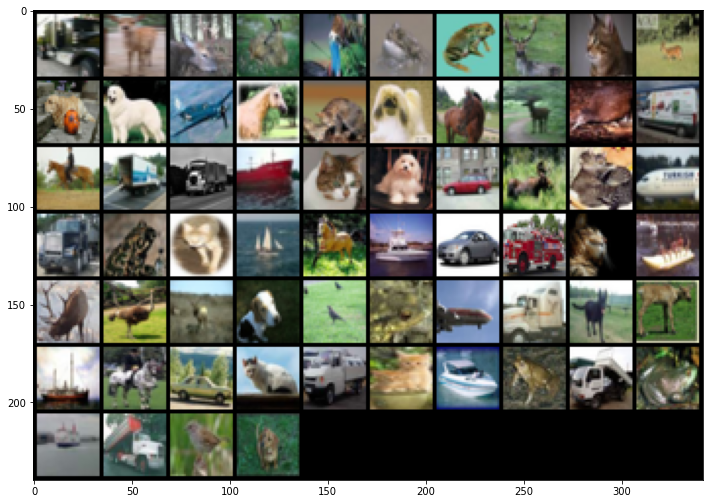

In [ ]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
def show_image(dataset):
  for images, labels in dataset:
    fig, ax = plt.subplots(figsize=(12,12))
    ax.imshow(make_grid(images, 10).permute(1,2,0))
    break

show_image(trainset)


In [ ]:
import torch
import torch.nn as nn

class conv_block(nn.Module):
  def __init__(
      self, in_channels, intermidiate_channels, identity_downsample = None, stride=1):
      super(conv_block, self).__init__()
      self.expansion = 4
      self.conv1= nn.Conv2d( in_channels,  intermidiate_channels, kernel_size=1, stride=1, padding=0 )
      self.bn1 = nn.BatchNorm2d(intermidiate_channels)

      self.conv2 = nn.Conv2d(intermidiate_channels, intermidiate_channels, kernel_size =3, stride=stride, padding=1)
      self.bn2 = nn.BatchNorm2d(intermidiate_channels)

      self.conv3 = nn.Conv2d(intermidiate_channels, intermidiate_channels * self.expansion, kernel_size=1, stride=1, padding =0)
      self.bn3 = nn.BatchNorm2d(intermidiate_channels* self.expansion)

      self.relu = nn.ReLU()
      self.identity_downsample = identity_downsample
      self.stride = stride

  def forward(self, x):
    identity = x.clone()

    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu(x)
    x = self.conv2(x)
    x = self.bn2(x)
    x = self.relu(x)
    x = self.conv3(x)
    x = self.bn3(x)
    
    if self.identity_downsample is not None:
      identity = self.identity_downsample(identity)

    x += identity
    x = self.relu(x)

    return x

class 
(nn.Module):
    def __init__(self, conv_block, layers, img_channels, num_classes):
      super(ResNet, self).__init__()
      self.in_channels = 64
      self.conv1 = nn.Conv2d(img_channels, 64, kernel_size=7, stride=2, padding=3)
      self.bn1 = nn.BatchNorm2d(64)
      self.relu = nn.ReLU()
      self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

      self.layer1 = self._make_layer(
          conv_block, layers[0], intermidiate_channels=64, stride=1
      )
      self.layer2 = self._make_layer(
          conv_block, layers[1], intermidiate_channels=128, stride=1
      )
      self.layer3 = self._make_layer(
          conv_block, layers[2], intermidiate_channels=256, stride=1
      )
      self.layer4 = self._make_layer(
          conv_block, layers[3], intermidiate_channels=512, stride=1
      )

      self.avgpool = nn.AdaptiveAvgPool2d((1,1))
      self.fc = nn.Linear(512*4, num_classes)

    def forward(self, x):
      x = self.conv1(x)
      x = self.bn1(x)
      x = self.relu(x)
      x = self.maxpool(x)
      x = self.layer1(x)
      x = self.layer2(x)
      x = self.layer3(x)
      x = self.layer4(x)

      x = self.avgpool(x)
      x = x.reshape(x.shape[0], -1)
      x = self.fc(x)

      return x
    
    def _make_layer(self, conv_block, num_residual_blocks, intermidiate_channels, stride):
      identity_downsample = None
      layers = []

      if stride != 1 or self.in_channels != intermidiate_channels * 4:
        identity_downsample = nn.Sequential(
            nn.Conv2d(self.in_channels, intermidiate_channels*4, kernel_size=1, stride = stride),
            nn.BatchNorm2d(intermidiate_channels*4),
        )

      layers.append(conv_block(self.in_channels, intermidiate_channels, identity_downsample, stride))

      self.in_channels = intermidiate_channels*4

      for i in range(num_residual_blocks-1):
        layers.append(conv_block(self.in_channels, intermidiate_channels))

      return nn.Sequential(*layers)






In [ ]:
def get_default_device():
    return torch.device('cuda') if torch.cuda.is_available else torch.device('cpu')

def to_device(entity, device):
  if isinstance(entity, (list, tuple)):
    return [to_device(elem, device) for elem in entity]
  return entity.to(device, non_blocking = True)

class DeviceDataLoader():
  def __init__(self, dataloader, device):
    self.dl= dataloader
    self.device = device
  def __iter__(self):
    for b in self.dl:
      yield to_device(b , self.device)
  def __len__(self):
    return len(self.dl)

device = get_default_device()
trainset = DeviceDataLoader(trainset, device)
val_dl = DeviceDataLoader(val_dl, device)
testset = DeviceDataLoader(testset, device)




In [ ]:
model34 = ResNet(conv_block, [3,4,6,3], 3, 10)

In [ ]:
model34

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): conv_block(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (identity_downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affi

In [ ]:
#training network

def accuracy(logits, labels):
  pred, predClassId = torch.max(logits, dim=1)
  return torch.tensor(torch.sum(predClassId == labels).item() / len(logits))

def evaluate(model34, dl, loss_func):
  model34.eval()
  final_validate_loss = []
  batch_losses, batch_accs = [], []
  for images, labels in dl:
    with torch.no_grad():
      logits = model34(images)
    batch_losses.append(loss_func(logits, labels))
    batch_accs.append(accuracy(logits, labels))  
  epoch_avg_loss = torch.stack(batch_losses).mean()
  epoch_avg_acc = torch.stack(batch_accs).mean() 
  return epoch_avg_loss, epoch_avg_acc, final_validate_loss

def train(model34, trainset, val_dl, epochs, max_lr, loss_func, optim):
  optimizer = optim(model34.parameters(), max_lr)
  scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs*len(trainset))

  final_train_loss = []
  results = []
  for epoch in range(epochs):
    model34.train()
    train_losses =[]
    lrs= []
    for images, labels in trainset:
      logits = model34(images)
      loss = loss_func(logits, labels)
      train_losses.append(loss)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
      lrs.append(optimizer.param_groups[0]["lr"])
      scheduler.step()

    final_train_loss.append(train_losses)
    epoch_train_loss = torch.stack(train_losses).mean().item()
    epoch_avg_loss, epoch_avg_acc, final_val_loss = evaluate(model34, val_dl, loss_func)
   
    results.append({'avg_valid_loss': epoch_avg_loss, 'avg_valid_acc': epoch_avg_acc, 'avg_train_loss': epoch_train_loss, 'lr':lrs})
  
  return results, final_train_loss, final_val_loss

In [ ]:
model34 = to_device(model34, device)
epochs = 8
max_lr = 1e-2
loss_func = nn.functional.cross_entropy
optim = torch.optim.Adam
results, list_train_loss, list_val_loss = train(model34, trainset, val_dl, epochs, max_lr, loss_func, optim)


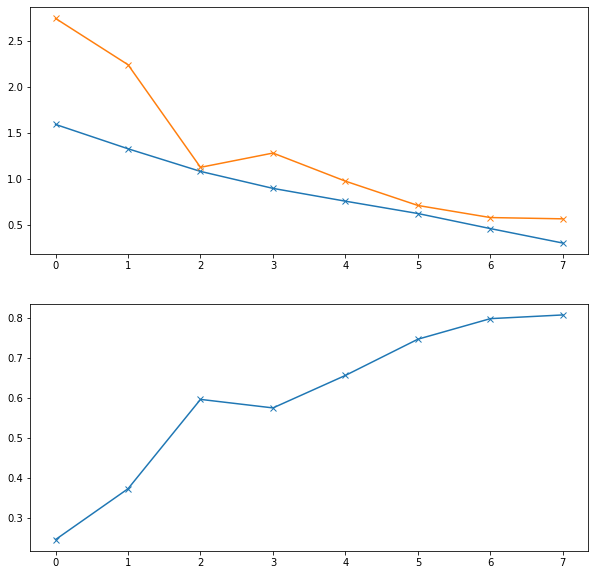

In [ ]:
import matplotlib.pyplot as plt
def plot(results, pairs):
  fig, axes = plt.subplots(len(pairs), figsize=(10,10))
  for i, pair in enumerate(pairs):
    for title, graphs in pair.items():
      axes[i].set_title = title
      axes[i].legend = graphs
      axes[i]
      for graph in graphs:
        axes[i].plot([result[graph] for result in results], '-x')
plot(results, ({"Losses vs epochs":[  "avg_train_loss", "avg_valid_loss"]}, {"Accuracy": ["avg_valid_acc"]}))


In [ ]:
for result in results:
  print(result['avg_valid_acc'])

tensor(0.2462)
tensor(0.3732)
tensor(0.5964)
tensor(0.5751)
tensor(0.6563)
tensor(0.7468)
tensor(0.7982)
tensor(0.8074)
